This notebook is based on [Lyft: Complete train and prediction pipeline](https://www.kaggle.com/huanvo/lyft-complete-train-and-prediction-pipeline)

In [1]:
import sys
sys.path.append('../lib/lyft-l5kit-unofficial-fix')

from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from tqdm import tqdm

import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import matplotlib.pyplot as plt

import os
import random
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
l5kit.__version__

'1.1.0'

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

## Configs

In [4]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'data_path': "../input/lyft-motion-prediction-autonomous-vehicles",
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_resnet34_output",
        'lr': 1e-3,
#         'weight_path': "../input/lyft-pretrained-model-hv/model_multi_update_lyft_public.pth",
        'weight_path': "./models/model_lstm0_output_70000_plus_40000.pth",
        'train': False,
        'predict': True
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 4
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'max_num_steps': 101,
        'checkpoint_every_n_steps': 20,
    },
       'val_data_loader': {
        'key': 'scenes/validate_chopped_100/validate.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 8
    },
    'val_params': {
        'max_num_steps': 5000,
    }
}

In [5]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

## Loss function

In [6]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

## Model

Next we define the baseline model. Note that this model will return three possible trajectories together with confidence score for each trajectory.

In [7]:
# https://discuss.pytorch.org/t/solved-concatenate-time-distributed-cnn-with-lstm/15435
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.LSTM(64, 512, 2, batch_first=True)
        )


        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        batch_size, timesteps, H, W = x.size()
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = x.view(batch_size, 8, 64)
        x, state = self.head(x)
        x = torch.flatten(x, 1)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [8]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

Now let us initialize the model and load the pretrained weights. Note that since the pretrained model was trained on GPU, you also need to enable GPU when running this notebook.

In [9]:
# !git clone https://github.com/lyft/l5kit

In [10]:
from collections import OrderedDict, defaultdict

import sys
sys.path.append('../l5kit/l5kit/l5kit/evaluation')

from csv_utils import read_gt_csv, read_pred_csv, write_gt_csv, write_pred_csv

In [11]:
# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
from torch.utils.data.sampler import SubsetRandomSampler

random_seed = 42 + 5
shuffle_dataset = True

# ===== INIT VAL DATASET============================================================
eval_base_path = '../input/lyft-validate-chopped'
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)

eval_zarr_path = str(Path(eval_base_path) / 'validate.zarr' )
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)

# Creating data indices for training and validation splits:
dataset_size = len(eval_dataset)
indices = list(range(dataset_size))
split = cfg["val_params"]["max_num_steps"]
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
val_indices = indices[:split]

valid_sampler = SubsetRandomSampler(val_indices)
val_dataloader = DataLoader(eval_dataset, sampler=valid_sampler, batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])

print("Valid {}".format(len(val_indices)))

Valid 5000


In [12]:
ground_truth_path = eval_gt_path
ground_truth = OrderedDict()
inference = OrderedDict()

for el in read_gt_csv(ground_truth_path):
    ground_truth[el["track_id"] + el["timestamp"]] = el

In [13]:
# ==== INIT MODEL=================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftMultiModel(cfg)

print(device)

cuda:0


In [14]:
results = []
for i in range(0,12000, 1000):
    weight_path = "./models/model_lstm0_output_416k_plus_"+str(i)+".pth"
    #load weight if there is a pretrained model
    if weight_path:
        model.load_state_dict(torch.load(weight_path))

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])
    print(f'device {device}')

    # ==== EVAL LOOP
    model.eval()
    torch.set_grad_enabled(False)

    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    confidences_list = []
    agent_ids = []

    progress_bar = tqdm(val_dataloader)
    for data in progress_bar:
        loss, preds, confidences = forward(data, model, device)

        #fix for the new environment
        preds = preds.cpu().numpy()
        world_from_agents = data["world_from_agent"].numpy()
        centroids = data["centroid"].numpy()
        coords_offset = []

        # convert into world coordinates and compute offsets
        for idx in range(len(preds)):
            for mode in range(3):
                preds[idx, mode, :, :] = transform_points(preds[idx, mode, :, :], world_from_agents[idx]) - centroids[idx][:2]

        future_coords_offsets_pd.append(preds.copy())
        confidences_list.append(confidences.cpu().numpy().copy())
        timestamps.append(data["timestamp"].numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy()) 
    
    pred_path = 'pred_short.csv'
    write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
               confs = np.concatenate(confidences_list)
              )

    inference = OrderedDict()

    for el in read_pred_csv(pred_path):
        inference[el["track_id"] + el["timestamp"]] = el
        
    metrics = [neg_multi_log_likelihood, time_displace]
    metrics_dict = defaultdict(list)

    for key, ground_truth_value in ground_truth.items():
        gt_coord = ground_truth_value["coord"]
        avail = ground_truth_value["avail"]

        # we subsampled the eval datset -> not every timestamp is available
        if key in inference:
            pred_coords = inference[key]["coords"]
            conf = inference[key]["conf"]
            for metric in metrics:
                metrics_dict[metric.__name__].append(metric(gt_coord, pred_coords, conf, avail))

    metric = {metric_name: np.mean(values, axis=0) for metric_name, values in metrics_dict.items()}
#     print({metric_name: np.mean(values, axis=0) for metric_name, values in metrics_dict.items()})
#     print(metric)
    my_result = metric['neg_multi_log_likelihood']
    print(weight_path, my_result)
    results.append(my_result)
    

  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


./models/model_lstm0_output_416k_plus_0.pth 23.333442194270038


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


./models/model_lstm0_output_416k_plus_1000.pth 23.781278421274926


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:49<00:00,  2.87it/s]


./models/model_lstm0_output_416k_plus_2000.pth 21.758474613787822


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:49<00:00,  2.87it/s]


./models/model_lstm0_output_416k_plus_3000.pth 24.35036150883883


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:52<00:00,  2.77it/s]


./models/model_lstm0_output_416k_plus_4000.pth 24.477072077351455


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


./models/model_lstm0_output_416k_plus_5000.pth 24.376116937804383


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:51<00:00,  2.81it/s]


./models/model_lstm0_output_416k_plus_6000.pth 25.06165768913196


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:52<00:00,  2.78it/s]


./models/model_lstm0_output_416k_plus_7000.pth 25.008784969581914


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


./models/model_lstm0_output_416k_plus_8000.pth 26.910025346427247


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:51<00:00,  2.82it/s]


./models/model_lstm0_output_416k_plus_9000.pth 24.11895601499331


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:53<00:00,  2.75it/s]


./models/model_lstm0_output_416k_plus_10000.pth 27.089822207158363


  0%|          | 0/313 [00:00<?, ?it/s]

device cuda:0


100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


./models/model_lstm0_output_416k_plus_11000.pth 23.393010103532834


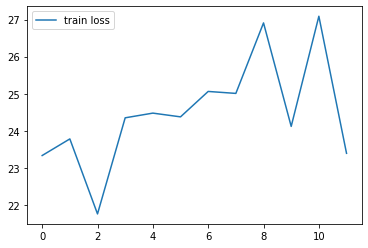

In [15]:
losses_train = results
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()